Ici, nous prédisons les émissions de C02 des propriétés. 

Contrairement au notebbok de prédiction de la consommation totale d'énergie, nous ne ferons que du onehotencoding en ce qui concerne les variables catégorielles.

# 1 - Importation des librairies et du fichier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import random

from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from category_encoders import TargetEncoder

from xgboost import XGBRegressor

import shap
shap.initjs()

import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

C:\Users\cheno\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
file = "file_cleaned.csv"
data = pd.read_csv(file)

In [3]:
# On fixe le seed des random_state
seed = 1234

In [4]:
def log10_transform(x):
    '''
    Retourne le logarithme en base 10 de x
    Args:
        x (float) : Nombre réel strictement positif
    '''
    return np.log10(x)

Les modèles que nous allons entrainer vont prédire le logarithme en base 10 de y. Les métriques classiques retourneront donc l'erreur sur le logarithme alors que nous souhaitons avoir l'erreur sur la valeur réelle. Nous allons donc créer une métrique personnalisée afin de corriger celà.

In [5]:
def custom_metric(y, y_pred):
    '''
    Retourne 100 * sum(|10^y - 10^y_pred|) / sum(10^y)
    Args:
        y (ndarray shape (n,)) : log10 des valeurs réelles
        y_pred (ndarray shape (n,)) : log10 des valeurs prédites
    '''
    return 100 * np.sum(np.abs(10**y - 10**y_pred)) / np.sum(10**y)

In [6]:
custom_error = make_scorer(custom_metric, greater_is_better=False)

Ecrivons une fonction qui va retourner les résultats de GridSearchCV sous forme de DataFrame.

In [7]:
def resultize(grid, rank_by):
    '''
    Retourne les résultats de GridSearchCV sous forme de dataframe
    Args:
        grid : une instanciation de sklearn.model_selection.GridSearchCV
        rank_by : la colonne selon laquelle trier les résultats
    Returns:
        res (DataFrame) : le dataframe des résultats de grid
    '''
    res = pd.DataFrame(grid.cv_results_)
    cols = [col for col in res.columns if "split" not in col]
    res = res[cols]
    res = res.sort_values(rank_by).reset_index(drop=True)
    
    return res

Ecrivons une fonction qui va enregistrer dans un dictionnaire les paramètres et les métriques du meilleur résultat de cross validation de chacun des modèles que nous allons essayer.

In [8]:
cols=["mean_test_custom_error", "std_test_custom_error",
      "mean_train_custom_error", "std_train_custom_error",
      "mean_fit_time", "std_fit_time", "params",]

best_models_results = {
                       "model_name": [], 
                       "mean_test_custom_error": [],
                       "std_test_custom_error": [],
                       "mean_train_custom_error": [],
                       "std_train_custom_error": [],
                       "mean_fit_time": [],
                       "std_fit_time": [],
                       "parameters": [],
                      }

In [9]:
def append_results(dict_, grid, model_name, columns, idx=0):
    '''
    Ajoute les résultats de GridSearchCV dans dict_
    Args:
        dict_ (dict of lists, len=n)
        grid : une instanciation de sklearn.model_selection.GridSearchCV
        model_name (string) : the name of the model we append
        columns (list of strings, len=n-1) : les colonnes à extraire de grid
        idx (int) : l'indice du modèle retenu
    '''
    # On enregistre les clés de dict_ dans une liste
    keys_ = list(dict_)
    
    dict_[keys_[0]].append(model_name)
    for key_, col in list(zip(keys_[1:], columns)):
        dict_[key_].append(resultize(grid, "rank_test_custom_error")\
                           .loc[[idx], col].values[0])

# 2 - GridSearchCV

#### Selection des features et du target

In [10]:
categorical_features = ["CouncilDistrictCode", "YearBuilt_20"]
numerical_features = ["NumberofFloors", "NumberOfPropertyUseTypes", 
                      "PropertyGFATotal"]
ratio_features = ["OfficeRatio", "OtherRatio", "ParkingRatio", 
                  "RecreationRatio", "ResidenceRatio", "RestaurantRatio", 
                  "SchoolRatio", "StoreRatio", "WarehouseRatio",
                  "ElectricityRatio", "SteamUseRatio",]

X = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features]]
y = data.copy().loc[:, "TotalGHGEmissions"]

# Comme évoqué dans le notebook d'exploration, nous allons appliquer une
# transformation logarithmique au target.
y = np.log10(y)

#### Séparation des données

In [11]:
# La stratification sert à s'assurer que le split sélectionne des individus
# statistiques avec des émissions de CO2 variées (du moins polluant au plus
# polluant)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=seed, 
                     stratify=data["GHGEmissionsIntensity_bins"])

#### Transformation des colonnes

In [12]:
r_scaler = RobustScaler()
log_transformer = FunctionTransformer(log10_transform)
oh_enc = OneHotEncoder(drop="first")

ct_1 = ColumnTransformer(
     transformers=[("log_transformer", log_transformer, ["PropertyGFATotal"]), 
                   ("one_hot_encoder", oh_enc, categorical_features), 
                   ("scaler", r_scaler, ["NumberofFloors"])
                  ], 
    remainder="passthrough",
    n_jobs=-1)

#### Résulats avec une regression naïve

In [13]:
dum = DummyRegressor(strategy="mean")

# Entrainement
pipe_dum = Pipeline(steps=[("preprocessing", ct_1), ("dummy", dum)])
pipe_dum.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_dum = pipe_dum.predict(X_test)

# Evaluate
print(f"custom error : {custom_metric(y_test, y_pred_dum):.1f}")

custom error : 81.6


## 2.1 - Ridge

In [14]:
ridge = Ridge(random_state=seed)

# Grille de paramètres
param_grid = {"alpha": [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                        0.3, 0.6, 1, 3, 6, 10]}

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_ridge = GridSearchCV(
                          estimator=ridge, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("grid_ridge", grid_ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_ridge',
                 GridSearchCV(cv=5, estimator=Ridge(random_state=1234),
                              n_jobs=-1,
                              param_grid={

In [15]:
# Résultat de GridSearch
resultize(pipe_ridge.named_steps["grid_ridge"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.001601,0.000490,0.001009,0.000009,3,{'alpha': 3},-46.708484,2.942358,1,-45.725157,0.712385
1,0.001310,0.000406,0.001197,0.000401,6,{'alpha': 6},-46.857292,2.863656,2,-45.877177,0.704546
2,0.001623,0.000509,0.001337,0.000601,1,{'alpha': 1},-46.943876,3.141494,3,-45.943175,0.669200
3,0.001401,0.000490,0.001400,0.000491,0.6,{'alpha': 0.6},-47.048477,3.238876,4,-46.020358,0.655288
4,0.001597,0.000491,0.001005,0.000633,0.3,{'alpha': 0.3},-47.165558,3.338171,5,-46.092063,0.645110
5,0.001601,0.000490,0.000999,0.000002,0.1,{'alpha': 0.1},-47.258146,3.426666,6,-46.147353,0.641728
6,0.001593,0.000493,0.001207,0.000396,0.06,{'alpha': 0.06},-47.281665,3.449317,7,-46.159592,0.641893
7,0.001800,0.000400,0.001002,0.000006,0.03,{'alpha': 0.03},-47.300632,3.466703,8,-46.169167,0.642216
8,0.001799,0.000401,0.001400,0.000489,0.01,{'alpha': 0.01},-47.313850,3.478122,9,-46.175654,0.642425
9,0.002601,0.000490,0.001999,0.000632,0.006,{'alpha': 0.006},-47.316523,3.480418,10,-46.176995,0.642496


In [16]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_ridge.named_steps["grid_ridge"],  
               "ridge_ohe", 
               cols)

## 2.2 - Linear SVR

In [17]:
linear_svr = LinearSVR(random_state=seed, tol=0.1)

# Grille de paramètres
param_grid = {
              "C": np.logspace(-2, 3, 6),
              "epsilon": [0, 0.1, 1],
              "max_iter": [1e3, 5e3, 1e4]
             }

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_linear_svr = GridSearchCV(
                              estimator=linear_svr, 
                              param_grid=param_grid, 
                              cv=5, 
                              scoring=score,
                              refit="custom_error",
                              return_train_score=True,
                              verbose=2,
                              n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_linear_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("grid_linear_svr", grid_linear_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_linear_svr.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_linear_svr',
                 GridSearchCV(cv=5,
                              estimator=LinearSVR(random_state=1234, tol=0.1),
                              n_job

In [18]:
# Résultat de GridSearch
resultize(pipe_linear_svr.named_steps["grid_linear_svr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_max_iter,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.151700,0.023827,0.001400,0.000490,10.0,0.1,10000.0,"{'C': 10.0, 'epsilon': 0.1, 'max_iter': 10000.0}",-47.920371,4.180649,1,-46.315914,0.512205
1,0.149916,0.004988,0.001200,0.000400,10.0,0.1,5000.0,"{'C': 10.0, 'epsilon': 0.1, 'max_iter': 5000.0}",-47.920371,4.180649,1,-46.315914,0.512205
2,0.017259,0.001263,0.001023,0.000046,1.0,0.1,10000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 10000.0}",-49.535917,3.621180,3,-47.959485,2.286885
3,0.016997,0.000893,0.001205,0.000410,1.0,0.1,5000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 5000.0}",-49.535917,3.621180,3,-47.959485,2.286885
4,0.016457,0.000703,0.001400,0.000490,1.0,0.1,1000.0,"{'C': 1.0, 'epsilon': 0.1, 'max_iter': 1000.0}",-49.535917,3.621180,3,-47.959485,2.286885
5,0.003598,0.000489,0.001203,0.000401,0.1,0.1,10000.0,"{'C': 0.1, 'epsilon': 0.1, 'max_iter': 10000.0}",-50.337737,4.693637,6,-49.380297,1.144520
6,0.003354,0.000771,0.001490,0.000650,0.1,0.1,1000.0,"{'C': 0.1, 'epsilon': 0.1, 'max_iter': 1000.0}",-50.337737,4.693637,6,-49.380297,1.144520
7,0.004865,0.001242,0.001402,0.000488,0.1,0.1,5000.0,"{'C': 0.1, 'epsilon': 0.1, 'max_iter': 5000.0}",-50.337737,4.693637,6,-49.380297,1.144520
8,0.015057,0.001607,0.001600,0.000490,1.0,0,10000.0,"{'C': 1.0, 'epsilon': 0, 'max_iter': 10000.0}",-50.441445,1.142947,9,-49.092746,2.109764
9,0.014658,0.001336,0.001802,0.000396,1.0,0,5000.0,"{'C': 1.0, 'epsilon': 0, 'max_iter': 5000.0}",-50.441445,1.142947,9,-49.092746,2.109764


In [19]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_linear_svr.named_steps["grid_linear_svr"],  
               "linear_svr_ohe", 
               cols,
               idx=1)

## 2.3 - Polynomial kernel SVR

In [20]:
poly_svr = KernelRidge(kernel="poly")

# Grille de paramètres
param_grid = {
              "degree": np.arange(2,6), 
              "coef0": [0, 0.5, 1], 
              "alpha": np.logspace(-2, 3, 6),
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_poly_svr = GridSearchCV(
                            estimator=poly_svr, 
                            param_grid=param_grid, 
                            cv=5, 
                            scoring=score,
                            refit="custom_error",
                            return_train_score=True,
                            verbose=2,
                            n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_poly_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                ("grid_poly_svr", grid_poly_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_poly_svr.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_poly_svr',
                 GridSearchCV(cv=5, estimator=KernelRidge(kernel='poly'),
                              n_jobs=-1,
                              param_g

In [21]:
# Résultat de GridSearch
resultize(pipe_poly_svr.named_steps["grid_poly_svr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_coef0,param_degree,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.068115,0.011057,0.004884,0.001831,1.0,1,2,"{'alpha': 1.0, 'coef0': 1, 'degree': 2}",-4.638478e+01,2.639615e+00,1,-44.408748,0.650474
1,0.055941,0.008171,0.004852,0.001338,1.0,0.5,2,"{'alpha': 1.0, 'coef0': 0.5, 'degree': 2}",-4.648607e+01,2.568054e+00,2,-44.550651,0.635696
2,0.058257,0.011732,0.004476,0.001140,1.0,0,2,"{'alpha': 1.0, 'coef0': 0, 'degree': 2}",-4.671039e+01,2.713286e+00,3,-44.867349,0.686101
3,0.077121,0.010049,0.007140,0.003112,0.1,0,2,"{'alpha': 0.1, 'coef0': 0, 'degree': 2}",-4.713777e+01,3.862026e+00,4,-42.410384,0.897280
4,0.054110,0.009346,0.006153,0.002391,0.1,1,2,"{'alpha': 0.1, 'coef0': 1, 'degree': 2}",-4.734770e+01,4.078701e+00,5,-42.160375,0.812579
5,0.070221,0.006127,0.005954,0.001841,0.1,0.5,2,"{'alpha': 0.1, 'coef0': 0.5, 'degree': 2}",-4.762941e+01,4.354177e+00,6,-42.470494,0.849001
6,0.106279,0.006556,0.017962,0.000949,10.0,1,3,"{'alpha': 10.0, 'coef0': 1, 'degree': 3}",-4.773559e+01,2.242709e+00,7,-46.141889,0.542304
7,0.056994,0.005305,0.005999,0.001262,0.01,1,2,"{'alpha': 0.01, 'coef0': 1, 'degree': 2}",-4.863814e+01,4.990533e+00,8,-37.510319,0.738921
8,0.121532,0.015733,0.020810,0.002715,1.0,1,3,"{'alpha': 1.0, 'coef0': 1, 'degree': 3}",-4.868133e+01,4.470136e+00,9,-42.703580,0.800116
9,0.116173,0.007071,0.005401,0.000490,0.01,0,2,"{'alpha': 0.01, 'coef0': 0, 'degree': 2}",-4.871627e+01,5.678523e+00,10,-38.848855,0.892738


In [22]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_poly_svr.named_steps["grid_poly_svr"], 
               "poly_svr_ohe", 
               cols)

## 2.4 - Radial kernel SVR

In [23]:
radial_svr = KernelRidge(kernel="rbf")

# Grille de paramètres
param_grid = {
              "gamma": np.logspace(-3, 3, 7), 
              "alpha": np.logspace(-3, 3, 7)
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_radial_svr = GridSearchCV(
                        estimator=radial_svr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_radial_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("grid_radial_svr", grid_radial_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_radial_svr.fit(X_train, y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...l_svr',
                 GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
                              n_jobs=-1,
                              param_grid={

In [24]:
# Résultat de GridSearch
resultize(pipe_radial_svr.named_steps["grid_radial_svr"], 
          "rank_test_custom_error").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_gamma,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.110278,0.018965,0.015414,0.001962,0.01,0.01,"{'alpha': 0.01, 'gamma': 0.01}",-46.299921,3.267104,1,-40.584647,0.467700
1,0.075914,0.019227,0.009798,0.002400,0.01,0.001,"{'alpha': 0.01, 'gamma': 0.001}",-46.341359,2.818251,2,-45.130283,0.684807
2,0.095488,0.010426,0.012539,0.001581,0.1,0.01,"{'alpha': 0.1, 'gamma': 0.01}",-46.386765,3.189376,3,-44.342295,0.648326
3,0.118395,0.016075,0.029802,0.007651,0.001,0.001,"{'alpha': 0.001, 'gamma': 0.001}",-46.722148,3.184035,4,-44.191339,0.693460
4,0.100331,0.007795,0.014849,0.002800,0.1,0.1,"{'alpha': 0.1, 'gamma': 0.1}",-48.140806,2.136778,5,-34.181773,0.322282
5,0.107664,0.013170,0.015858,0.002408,0.01,0.1,"{'alpha': 0.01, 'gamma': 0.1}",-49.262095,2.918335,6,-20.565112,0.496890
6,0.126140,0.011778,0.018657,0.008932,0.001,0.01,"{'alpha': 0.001, 'gamma': 0.01}",-49.757607,3.174192,7,-34.648538,0.525474
7,0.144348,0.007679,0.018232,0.002499,1.0,0.1,"{'alpha': 1.0, 'gamma': 0.1}",-52.359039,3.240977,8,-47.842943,0.648638
8,0.066015,0.014859,0.009540,0.002605,0.1,0.001,"{'alpha': 0.1, 'gamma': 0.001}",-55.937663,1.603296,9,-55.110190,0.645560
9,0.137676,0.004830,0.017864,0.003382,1.0,0.01,"{'alpha': 1.0, 'gamma': 0.01}",-57.223047,1.854538,10,-56.247190,0.593661


In [25]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_radial_svr.named_steps["grid_radial_svr"], 
               "radial_svr_ohe", 
               cols,
               idx=1)

## 2.5 - Random Forest

In [26]:
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed)

# Grille de paramètres
param_grid = {
              "n_estimators": [50, 64, 100], 
              "max_depth": [3, 5, 7],
              "min_samples_leaf": [5, 7, 10],
              "max_features": [5, 6, 7],
              "max_samples": [0.5, 0.75, 0.9]
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grile
grid_rfr = GridSearchCV(
                        estimator=rfr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                             )

# On automatise le preprocessing et l'entrainement 
pipe_rfr = Pipeline(steps=[("preprocessing", ct_1), 
                           ("grid_rfr", grid_rfr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(n_jobs=-1,
                                                      

In [27]:
# Résultat de GridSearch
resultize(pipe_rfr.named_steps["grid_rfr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_n_estimators,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.293037,0.018771,0.040817,0.009897,7,7,0.9,5,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.456427,1.669659,1,-46.180887,0.139174
1,0.197879,0.032475,0.024499,0.002675,7,7,0.9,5,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.484901,1.368606,2,-46.403637,0.233839
2,0.147436,0.006144,0.021525,0.001713,7,7,0.9,5,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.544719,1.431555,3,-46.432784,0.209407
3,0.315654,0.048044,0.034184,0.001699,7,7,0.75,5,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.547144,1.796800,4,-46.370755,0.321375
4,0.291029,0.029023,0.036970,0.006917,7,7,0.9,7,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.864883,1.924274,5,-47.341359,0.225438
5,0.203770,0.031559,0.027914,0.001875,7,7,0.75,5,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-51.940041,1.771494,6,-46.788763,0.344370
6,0.150243,0.025404,0.025311,0.003366,7,7,0.9,7,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-52.044278,1.463165,7,-47.516015,0.480318
7,0.158518,0.019215,0.027774,0.003390,7,7,0.75,5,50,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-52.067713,1.652453,8,-46.687843,0.351131
8,0.172983,0.037159,0.024905,0.003710,7,7,0.9,7,64,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-52.078887,1.460743,9,-47.536665,0.428584
9,0.255064,0.016596,0.035498,0.005590,7,7,0.75,7,100,"{'max_depth': 7, 'max_features': 7, 'max_sampl...",-52.216828,1.766431,10,-48.016548,0.290421


In [28]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_rfr.named_steps["grid_rfr"], 
               "rfr_ohe", 
               cols,
               idx=31)

## 2.6 - XGBoost

In [29]:
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed)

# Grille de paramètres
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "gamma": [0, 5, 10],
    "reg_lambda": [0, 1, 5],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.4, 0.6, 0.8]
             }

# critère de sélection du meilleur modèle
# R² n'a pas de sens pour les modèles non linéaires
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_xgbr = GridSearchCV(
                        estimator=xgbr, 
                        param_grid=param_grid, 
                        cv=5, 
                        scoring=score,
                        refit="custom_error",
                        return_train_score=True,
                        verbose=2,
                        n_jobs=-1,
                        error_score="raise"
                      )

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("grid_xgbr", grid_xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('g...
                                                     tree_method=None,
                                                     validate_parameters=None,
             

In [30]:
# Résultat de GridSearch
resultize(pipe_xgbr.named_steps["grid_xgbr"], 
          "rank_test_custom_error").head(100)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_reg_lambda,param_subsample,params,mean_test_custom_error,std_test_custom_error,rank_test_custom_error,mean_train_custom_error,std_train_custom_error
0,0.375011,0.003491,0.005169,2.945106e-04,0.8,0,0.1,3,0,0.8,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.029632,1.740548,1,-33.513292,0.547638
1,0.343707,0.001599,0.005600,4.892045e-04,0.8,0,0.1,3,1,0.9,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.206750,1.415865,2,-34.191848,0.466128
2,0.296959,0.006145,0.005218,4.356639e-04,0.4,0,0.1,3,1,0.8,"{'colsample_bytree': 0.4, 'gamma': 0, 'learnin...",-45.300066,1.534783,3,-35.759667,0.308270
3,0.294543,0.009073,0.005400,4.897682e-04,0.4,0,0.1,3,1,0.7,"{'colsample_bytree': 0.4, 'gamma': 0, 'learnin...",-45.313233,1.957462,4,-35.646061,0.427149
4,0.364535,0.011725,0.005652,4.330058e-04,0.8,0,0.1,3,5,0.7,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.376500,1.542658,5,-36.269447,0.540925
5,0.523150,0.014046,0.005399,1.018123e-03,0.6,0,0.1,5,1,0.9,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-45.469904,1.448170,6,-22.764273,0.544556
6,0.608430,0.029198,0.006857,1.872795e-03,0.8,0,0.05,5,0,0.8,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.492901,1.500837,7,-28.660117,0.438393
7,0.411475,0.044821,0.011046,1.181635e-02,0.8,0,0.1,3,5,0.9,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.519091,1.636179,8,-35.712722,0.475062
8,0.391981,0.021441,0.005204,3.986221e-04,0.8,0,0.1,3,1,0.8,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin...",-45.539944,1.263514,9,-34.499376,0.771408
9,0.296690,0.029727,0.005215,9.847344e-04,0.6,0,0.1,3,0,0.7,"{'colsample_bytree': 0.6, 'gamma': 0, 'learnin...",-45.592902,1.973117,10,-34.083291,0.559258


In [31]:
# On enregistre les résultats du meilleur modèle
append_results(best_models_results, 
               pipe_xgbr.named_steps["grid_xgbr"],  
               "xgbr_ohe", 
               cols,
               idx=48)

# 3 - Sélection du modèle

In [32]:
dataresult = pd.DataFrame(best_models_results)
dataresult

,model_name,mean_test_custom_error,std_test_custom_error,mean_train_custom_error,std_train_custom_error,mean_fit_time,std_fit_time,parameters
0,ridge_ohe,-46.708484,2.942358,-45.725157,0.712385,0.001601,0.000490,{'alpha': 3}
1,linear_svr_ohe,-47.920371,4.180649,-46.315914,0.512205,0.149916,0.004988,"{'C': 10.0, 'epsilon': 0.1, 'max_iter': 5000.0}"
2,poly_svr_ohe,-46.384776,2.639615,-44.408748,0.650474,0.068115,0.011057,"{'alpha': 1.0, 'coef0': 1, 'degree': 2}"
3,radial_svr_ohe,-46.341359,2.818251,-45.130283,0.684807,0.075914,0.019227,"{'alpha': 0.01, 'gamma': 0.001}"
4,rfr_ohe,-53.918091,1.737619,-51.369547,0.466143,0.284777,0.020297,"{'max_depth': 7, 'max_features': 7, 'max_sampl..."
5,xgbr_ohe,-46.395237,1.622873,-39.896134,0.528342,0.305521,0.041198,"{'colsample_bytree': 0.8, 'gamma': 0, 'learnin..."


Nous allons re-entrainer les 6 modèles avec les meilleurs paramètres de GridSearchCV, mais cette fois-ci avec l'ensemble du train set.

In [33]:
# On enregistre les résultats de chacun des modèles
results = {"name": [],
           "train_custom_error": [],
           "test_custom_error": [],
           "train_time": [],}

### Ridge

In [34]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "ridge_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
ridge = Ridge(random_state=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("ridge", ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_ridge.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_ridge.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("ridge")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_ridge.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.020s
custom error : 45.9


### Linear SVR

In [35]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "linear_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
linear_svr = LinearSVR(random_state=seed, tol=0.1, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_linear_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("linear_svr", linear_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_linear_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_linear_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("linear svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_linear_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.170s
custom error : 46.1


### Polynomial kernel SVR

In [36]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "poly_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
poly_svr = KernelRidge(kernel="poly", **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_poly_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                ("poly_svr", poly_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_poly_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_poly_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("polynomial svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_poly_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.062s
custom error : 45.7


### Radial kernel SVR

In [37]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "radial_svr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
radial_svr = KernelRidge(kernel="rbf", **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_radial_svr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("radial_svr", radial_svr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_radial_svr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_radial_svr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("radial svr")
results["train_custom_error"].append(custom_metric(y_train, 
                                            pipe_radial_svr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.081s
custom error : 46.9


### Random Forest

In [38]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "rfr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
rfr = RandomForestRegressor(n_jobs=-1, random_state=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_rfr = Pipeline(steps=[("preprocessing", ct_1), 
                                  ("rfr", rfr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_rfr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_rfr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("random forest")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_rfr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.194s
custom error : 55.9


### XGBoost

In [39]:
# On récupère les paramètres de GridSearchCV 
mask = dataresult["model_name"] == "xgbr_ohe"
best_params = dataresult.loc[mask, "parameters"].values[0]

# On entraine le modèle avec ces paramètres
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_1), 
                            ("xgbr", xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_xgbr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_xgbr.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"custom error : {score_:.1f}")

# On enregistre les résultats
results["name"].append("xgboost")
results["train_custom_error"].append(custom_metric(y_train, 
                                                pipe_xgbr.predict(X_train)))
results["test_custom_error"].append(custom_metric(y_test, y_pred))
results["train_time"].append(elapsed_time)

Temps écoulé pour entrainer le modèle : 0.133s
custom error : 47.3


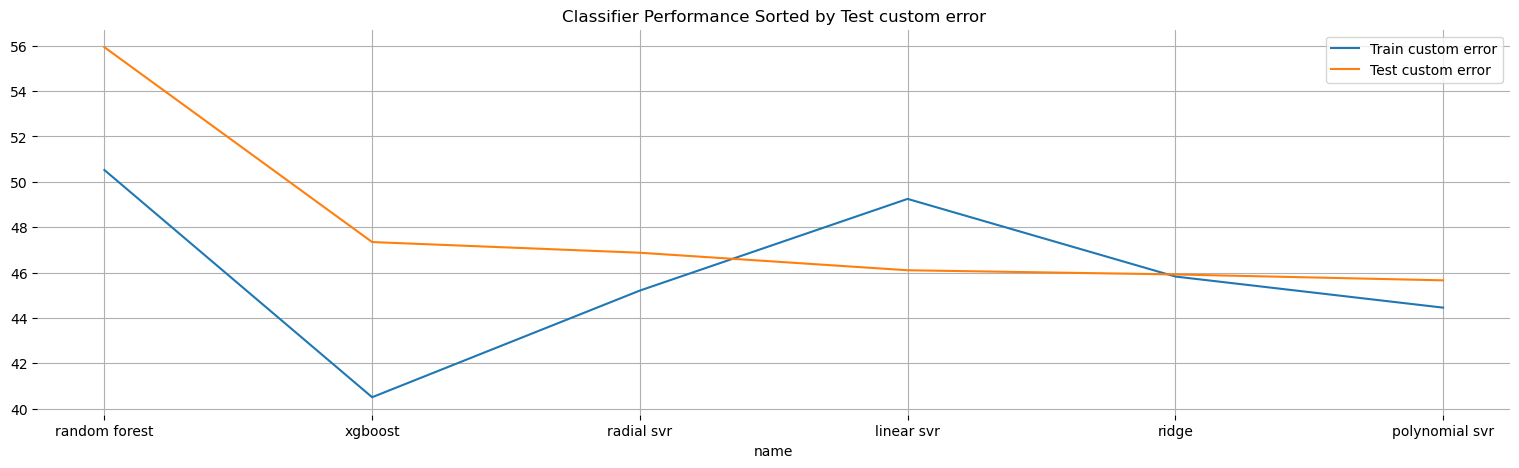

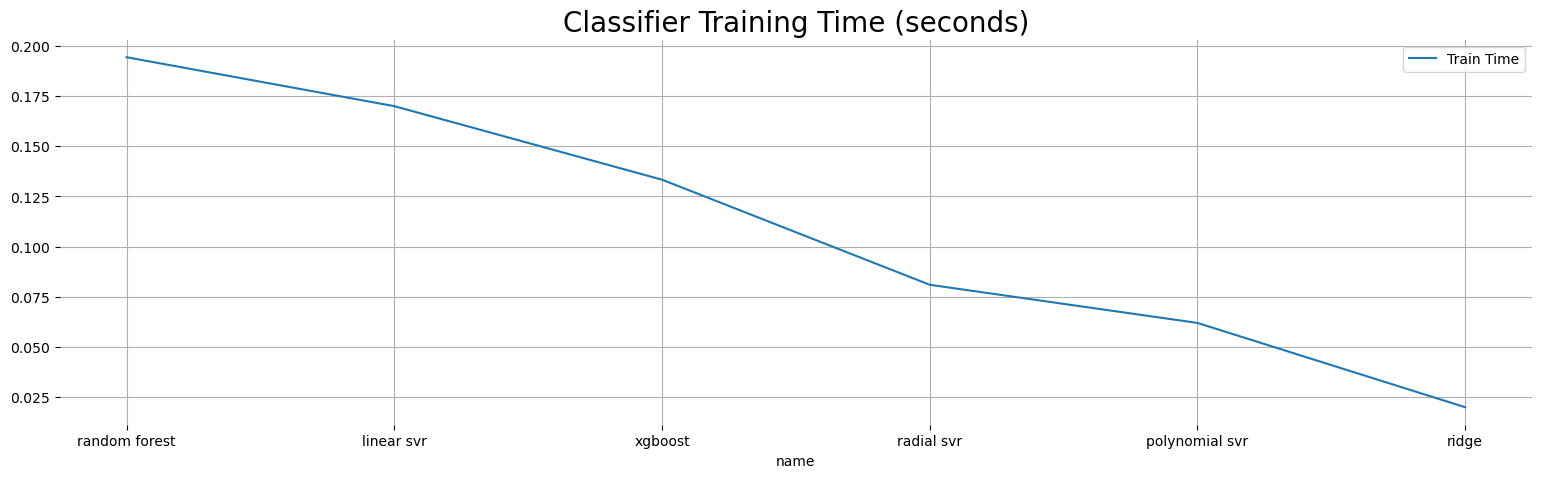

In [40]:
# Comparaison des scores et temps d'entrainement
#setup_plot()
results_df = pd.DataFrame(results)

# custom error
results_df.sort_values("test_custom_error", inplace=True, ascending=False) 
ax = results_df[["train_custom_error","test_custom_error", "name"]]\
        .plot(kind="line", x="name", figsize=(19,5), grid=True,
              title="Classifier Performance Sorted by Test custom error")
ax.legend(["Train custom error", "Test custom error"])
plt.box(False)

# Train time
results_df.sort_values("train_time", inplace=True, ascending=False)
ax = results_df[["train_time", "name"]].plot(kind="line", x="name", 
                                             figsize=(19,5), grid=True, 
                                title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)  

- Hormis RandomForest, tous les modèles commettent des erreurs dans le même ordre de grandeur.

Conclusion : Nous allons retenir Ridge comme modèle définitif. En plus d'être le plus rapide, il se généralise très bien.

Nous allons maintenant peaufiner l'optimisation des paramètres du modèle.

In [41]:
# ROUND 1

ridge = Ridge(random_state=seed)

# Grille de paramètres
param_grid = {"alpha": [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]}

# critère de sélection du meilleur modèle
score = {"custom_error": custom_error}

# initialiser une recherche sur grille
grid_ridge = GridSearchCV(
                          estimator=ridge, 
                          param_grid=param_grid, 
                          cv=5, 
                          scoring=score,
                          refit="custom_error",
                          return_train_score=True,
                          verbose=2,
                          n_jobs=-1,
                         )

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("grid_ridge", grid_ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
pipe_ridge.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('log_transformer',
                                                  FunctionTransformer(func=<function log10_transform at 0x0000022387771430>),
                                                  ['PropertyGFATotal']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['CouncilDistrictCode',
                                                   'YearBuilt_20']),
                                                 ('scaler', RobustScaler(),
                                                  ['NumberofFloors'])])),
                ('grid_ridge',
                 GridSearchCV(cv=5, estimator=Ridge(random_state=1234),
                              n_jobs=-1,
                              param_grid={

Les meilleurs paramètres restent inchangés. Il n'est donc pas nécessaire de continuer l'optimisation. Ces paramètres sont : 

In [42]:
pipe_ridge["grid_ridge"].best_params_

{'alpha': 3}

Nous allons re-entrainer le modèle avec ces derniers, sur l'ensemble du training set

In [43]:
best_params = pipe_ridge["grid_ridge"].best_params_

# On entraine le modèle avec ces paramètres
ridge = Ridge(random_state=seed, **best_params)

# On automatise le preprocessing et l'entrainement 
pipe_ridge = Pipeline(steps=[("preprocessing", ct_1), 
                             ("ridge", ridge)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_ridge.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_ridge.predict(X_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.3f}")
print(f"train custom error : \
    {custom_metric(y_train, pipe_ridge.predict(X_train)):.3f}")

Temps écoulé pour entrainer le modèle : 0.019s
test custom error : 45.916
train custom error :     45.824


# 4 - Analyse du modèle

## 4.1 - Erreurs du modèle

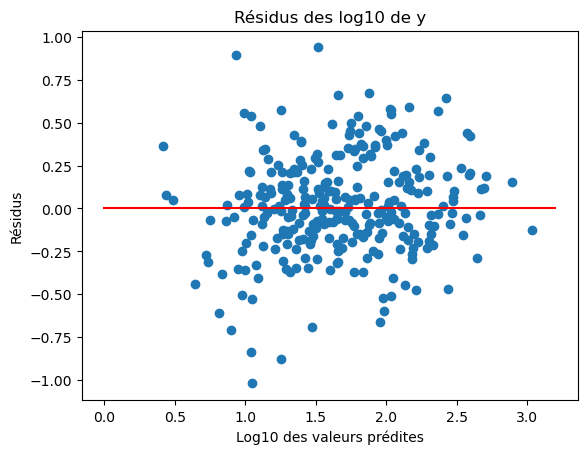

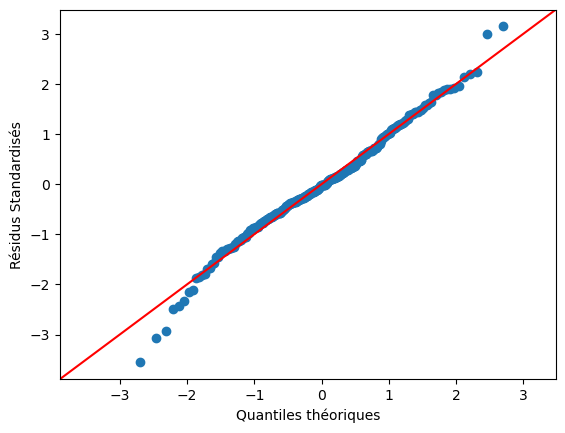

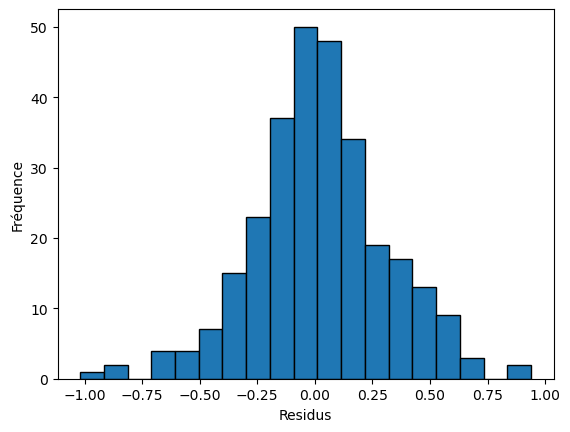

In [44]:
# Graphe des résidus
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.plot([0, 3.2], [0, 0], color="r")
plt.xlabel("Log10 des valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus des log10 de y")
plt.show()

# qqplot des résidus
sm.qqplot((residuals-residuals.mean())/residuals.std(), line='45')
plt.xlabel("Quantiles théoriques")
plt.ylabel("Résidus Standardisés")
plt.show()

# Histogramme des résidus
plt.hist(residuals, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residus")
plt.ylabel("Fréquence")
plt.show()

- Le 1er graphe montre que les résidus sont aléatoires, dispersés et centrés autour de 0. Aucune forme ou tendance n'est lisible dessus, ce qui signifie que les résidus ne représentent donc que le "bruit" du modèle. Pour rappel, c'est ce qui est souhaité. 
- Les 2 autres graphes montrent que les résidus suivent bien une loi normale centrée. 

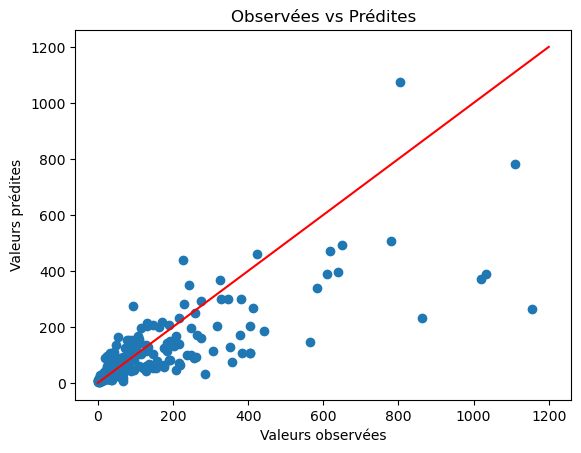

In [45]:
plt.scatter(10**y_test, 10**y_pred)
plt.plot([0, 1200], [0, 1200], color="r")
plt.xlabel("Valeurs observées")
plt.ylabel("Valeurs prédites")
plt.title("Observées vs Prédites")
plt.show()

Le modèle est assez correct pour des propriétés dont la consommation énergétique est inférieure à 400. Au delà de cette valeur, le modèle a tendance à largement sous-estimer la consommation énergétique.

## 4.2 - Feature importance

Le modèle retenu étant linéaire, on peut déduire l'importance de chaque feature, que ce soit globalement ou localement, uniquement en regardant les coefficients de la régression. 

Le modèle entrainé précédemment utilisait la fonction **ColumnTranformer**, qui a le défaut malheureusement de supprimer le nom des colonnes. Nous allons re-entrainer le modèle avec exactement les mêmes paramètres, mais avec pd.get_dummies de sorte à conserver le nom des colonnes.

Nota : Etant donné qu'on prédit log10(y), la feature d'importance ne peut que nous renseigner sur comment on obtient...log10(y). La consommation prédite vaut 10^y.

In [46]:
X_copy = X.copy()

# OneHotEncoding de X_copy
X_copy = pd.get_dummies(X_copy, columns=categorical_features, drop_first=True)

# On reffectue le split de X_copy,
X_train_copy, X_test_copy= \
    train_test_split(X_copy, test_size=0.2, random_state=seed, 
                     stratify=data["GHGEmissionsIntensity_bins"])

# Application de la transformation logarithmique de PropertyGFATotal
X_train_copy["PropertyGFATotal"] = \
    X_train_copy["PropertyGFATotal"].map(log10_transform)
X_test_copy["PropertyGFATotal"] = \
    X_test_copy["PropertyGFATotal"].map(log10_transform)

# Application du robust scaler
X_train_copy["NumberofFloors"] = \
    r_scaler.fit_transform(X_train_copy[["NumberofFloors"]])
X_test_copy["NumberofFloors"] = \
    r_scaler.transform(X_test_copy[["NumberofFloors"]])

# Entrainement du modèle
ridge_copy = Ridge(random_state=seed, **best_params)
ridge_copy.fit(X_train_copy, y_train)

Ridge(alpha=3, random_state=1234)

In [47]:
# Features of the training set
features = X_train_copy.columns.tolist()

# Coefficients associated with these coefficients
coefs = ridge_copy.coef_

# Feature importance
importance = pd.DataFrame({"features": features, "coefs": coefs})\
               .sort_values(["coefs"], ascending=False)

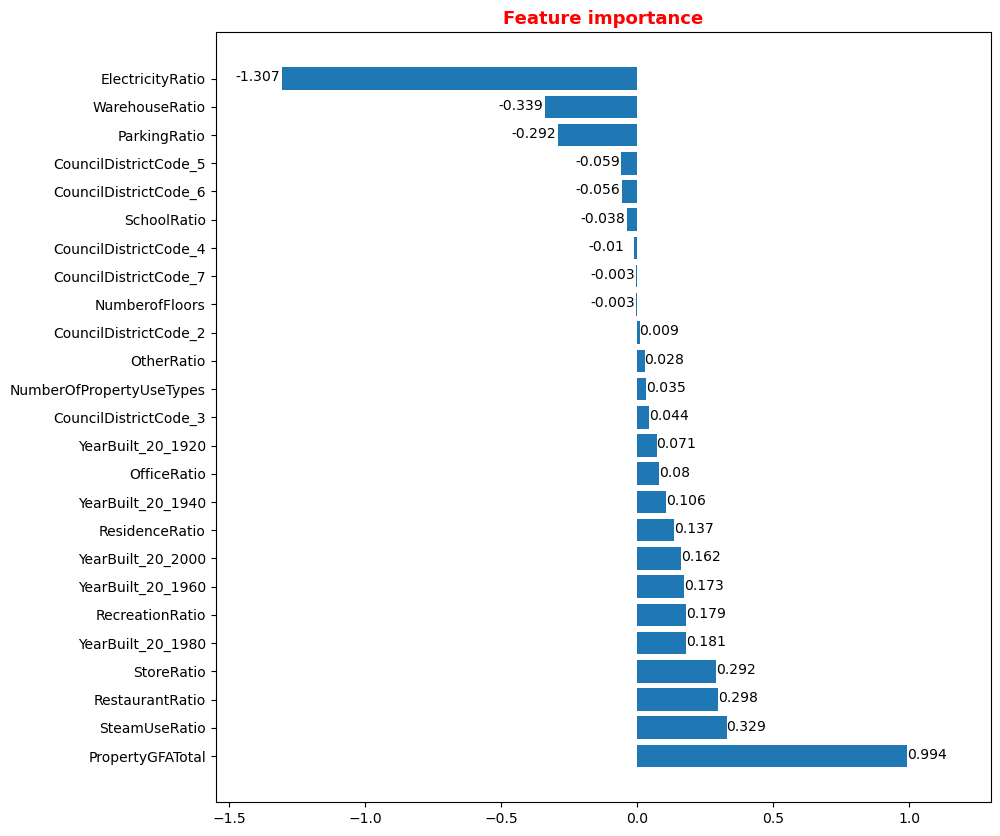

In [48]:
# Plot the feature importance graph
plt.figure(figsize=(10,10))
plt.barh(importance["features"], importance["coefs"])
plt.xlim(-1.55, 1.3)
plt.title("Feature importance", fontsize=13, fontweight="bold", color="red")
for i, v in enumerate(importance["coefs"]):
    margin = min(0, 0.17 * v / abs(v))
    plt.text(v+margin, i-0.1, str(round(v,3)))
plt.show()

- `PropertyGFATotal` et `ElectricityRatio` sont les features les plus importantes pour prédire les émissions de CO2.

# 5 - Intérêt de l'ENERGY STAR SCORE

Dans cette partie, nous allons ajouter la feature `ENERGYSTARScore` et voir si oui ou non elle améliore la précision du modèle. Pour rappel, sans prise en compte de cette feature, les résultats obtenus étaient les suivants : 

- Temps écoulé pour entrainer le modèle : 0.019s
- test custom error : 45.916
- train custom error :     45.824

**Nota : Afin de ne pas supprimer les propriétés dont `ENERGYSTARScore` n'est pas renseignée et qui représentent près de 40% des individus statistiques, nous nous servirons plutôt de XGBoost car l'imputation des valeurs manquantes est intégrée dans son algorithme de prédiction. Les paramètres utilisés seront ceux obtenus en partie 2, lors de GridSearchCV.**

In [49]:
# On re-sélectionne les features catégorielles
X_ess = data.copy().loc[:, [*categorical_features, *numerical_features, 
                        *ratio_features, "ENERGYSTARScore"]]

# On re-effectue le split de X_ess
X_ess_train, X_ess_test = \
    train_test_split(X_ess, test_size=0.2, random_state=seed, 
                     stratify=data["GHGEmissionsIntensity_bins"])

# On va également standardiser la feature ENERGYSTARScore
ct_3 = ColumnTransformer(
     transformers=[("log_transformer", log_transformer, ["PropertyGFATotal"]), 
                   ("one_hot_encoder", oh_enc, categorical_features), 
                   ("scaler", r_scaler, ["NumberofFloors", "ENERGYSTARScore"])
                  ], 
    remainder="passthrough",
    n_jobs=-1)

# Hyperparamètres du modèle
params_ = {
    "max_depth": 3,
    "learning_rate": 0.05,
    "gamma": 0,
    "reg_lambda": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.8
}

# On entraine le modèle avec ces paramètres
xgbr = XGBRegressor(objective="reg:squarederror", seed=seed, **params_)

# On automatise le preprocessing et l'entrainement 
pipe_xgbr = Pipeline(steps=[("preprocessing", ct_3), 
                            ("xgbr", xgbr)])

# On entraine le modèle pour obtenir les meilleurs paramètres
start_time = time.time()
pipe_xgbr.fit(X_ess_train, y_train)
elapsed_time = time.time() - start_time
print(f"Temps écoulé pour entrainer le modèle : {elapsed_time:.3f}s")

# Score
y_pred = pipe_xgbr.predict(X_ess_test)
score_ = custom_metric(y_test, y_pred)
print(f"test custom error : {score_:.3f}")
print(f"train custom error : \
    {custom_metric(y_train, pipe_xgbr.predict(X_ess_train)):.3f}")

Temps écoulé pour entrainer le modèle : 0.130s
test custom error : 42.996
train custom error :     37.312


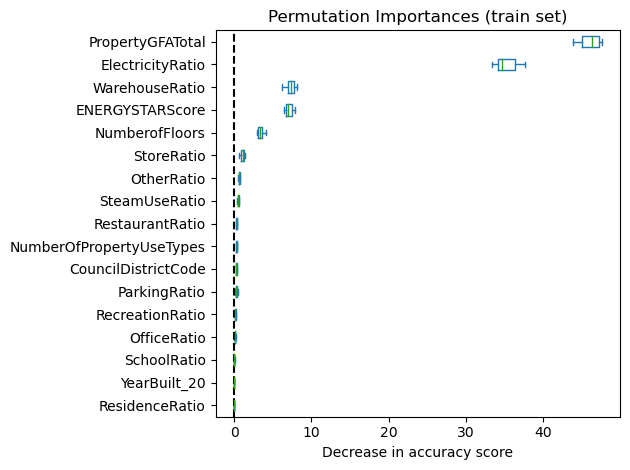

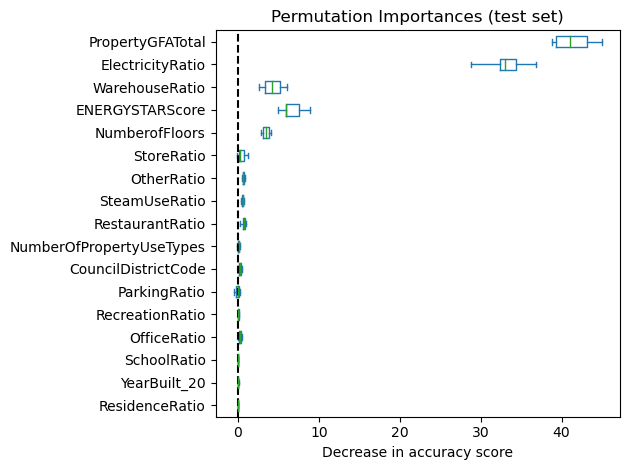

In [50]:
train_result = permutation_importance(
    pipe_xgbr, X_ess_train, y_train, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
test_results = permutation_importance(
    pipe_xgbr, X_ess_test, y_test, n_repeats=10, scoring=custom_error,
    random_state=seed, n_jobs=-1
)
sorted_importances_idx = train_result.importances_mean.argsort()

train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X_ess_train.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X_ess_train.columns[sorted_importances_idx],
)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

Il apparait que la prise en compte de `ENERGYSTARScore` améliore légèrement la précision de notre modèle. l'erreur diminue de 3%.  

En particulier, si on regarde l'influence moyenne relative des features sur le score modèle, on se rend compte que `ENERGYSTARScore` est après `PropertyGFATotal` et `WarehouseRatio` la feature la plus importante pour la prédiction.